In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

from tqdm import tqdm

import re

from PIL import Image
import requests

import warnings
warnings.filterwarnings('ignore')

In [22]:
data_path = "/opt/ml/data/"

In [23]:
users = pd.read_csv(data_path + 'users.csv')
books = pd.read_csv(data_path + 'books.csv')
train = pd.read_csv(data_path + 'train_ratings.csv')
test = pd.read_csv(data_path + 'test_ratings.csv')

In [24]:
print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('ratings shape: ', train.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
ratings shape:  (306795, 3)


In [25]:
base_used_books_cols = ['isbn', 'category', 'publisher', 'language', 'book_author']
books_cols = books.columns.tolist()
set(books_cols) - set(base_used_books_cols)

{'book_title', 'img_path', 'img_url', 'summary', 'year_of_publication'}

baseline 에서 books columns 중 위 컬럼들은 사용하지 않고 있음.

그 중 book title, img_path, img_url, summary 등은 사용하기 어렵다 하더라도 year_of_publication 은 사용할만 하지 않을까?

**year_of_publication** 변수를 사용해보자.

사용할 때, 이상한 값들 있었으므로 얘네 제거하는 전처리도 필요함 (1300년대 책)

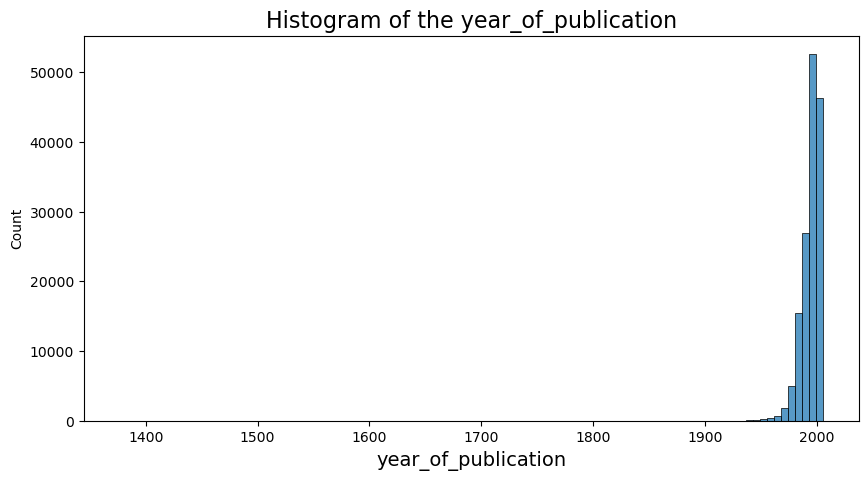

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(books['year_of_publication'],bins=100)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

In [27]:
books.loc[104259, 'year_of_publication'] = 2010.0
books.loc[121860, 'year_of_publication'] = 1997.0

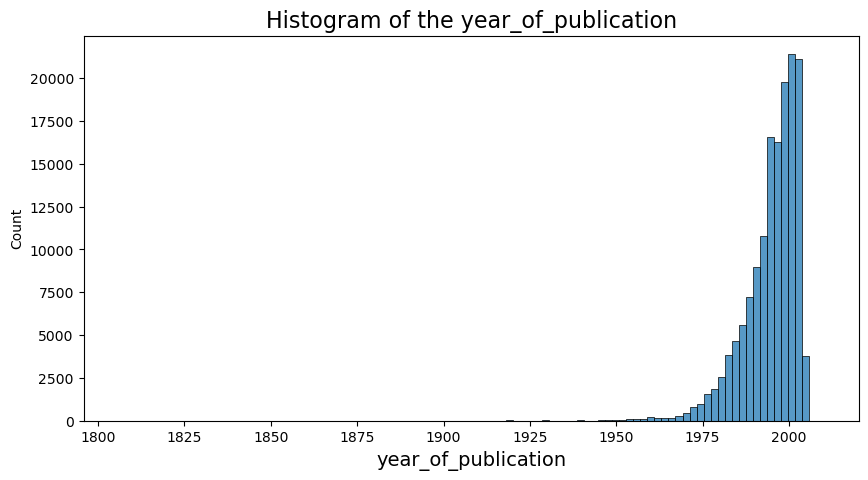

In [28]:
plt.figure(figsize=(10,5))
sns.histplot(books['year_of_publication'],bins=100)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

In [29]:
books[books['year_of_publication'] < 1900]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
129205,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable...",Benjamin Franklin,1806.0,Reprint Services Corp,http://images.amazon.com/images/P/0781228956.0...,en,NaN,Bonded Leather binding,images/0781228956.01.THUMBZZZ.jpg


In [30]:
books = books.drop(np.where(books['year_of_publication'] < 1900)[0][0]).reset_index(drop=True)
books

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...
149564,067161746X,The Bachelor Home Companion: A Practical Guide...,P.J. O'Rourke,1987.0,Pocket Books,http://images.amazon.com/images/P/067161746X.0...,en,['Humor'],A tongue-in-cheek survival guide for single pe...,images/067161746X.01.THUMBZZZ.jpg
149565,0767907566,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001.0,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,en,['Nature'],A daring twist on the travel-adventure genre t...,images/0767907566.01.THUMBZZZ.jpg
149566,0884159221,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.0,Lone Star Books,http://images.amazon.com/images/P/0884159221.0...,NaN,NaN,NaN,images/0884159221.01.THUMBZZZ.jpg
149567,0912333022,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,en,['Fiction'],These hilarious stories by the creator of publ...,images/0912333022.01.THUMBZZZ.jpg


In [31]:
train[train['isbn']=='0781228956']

,user_id,isbn,rating


1800 년도 책은 있지도 않으니까 그냥 drop 하자

------

'age' 변수에 관해서, 관점을 세가지로 해석해보았음

- 'age_map' 을 통하면 질적변수 -> cat_features 에 넣기 (EDAs: ver1)
- 'age_map' 을 사용해도 순서가 의미 -> cat_features 에 빼기 (EDAs: ver2)
- 그냥 'age' 자체를 사용하여 양적변수로 -> cat_features 에 빼기 (EDAs: ver3)

또한 공통적으로 **'age' 변수에 평균으로 결측을 대체하는 대신 median 값을 사용하였음**

-----

지금 우리 데이터에서 결측치가 어떻게 표현되는지 확인해보자

In [32]:
def replace_na(unique:np.array):
    unique = unique.tolist()
    unique.remove('na')
    unique = ['na'] + unique
    return unique

def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6
    
ratings1 = train.copy() ; ratings2 = test.copy()

users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0])
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1])
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2])
users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

# city는 있는데 country 없는 경우 채우기
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values

location_list = []
for location in tqdm(modify_location, desc='(1/4) fill country'):
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in tqdm(location_list, desc='(2/4) fill city'):
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]


# book preprocessing

# 유명 출판사 표기 오류로 그룹화되지 못하는 케이스 처리
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df = pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])
publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)

modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values

for publisher in tqdm(modify_list, desc = '(3/4) grouping same publisher'):
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

# category 대괄호 제거 및 소문자 변환
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
books['category'] = books['category'].str.lower()

# 43개의 high-category로 묶기
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
                'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
                'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
                'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

for category in tqdm(categories, desc = '(4/4) : high-categorizing'):
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

# 10개 이하 항목 others로 묶기
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
others_list = category_high_df[category_high_df['count']<10]['category'].values
books.loc[books[books['category_high'].isin(others_list)].index, 'category_high']='others'

# year_of_publication 변수 전처리
books.loc[104259, 'year_of_publication'] = 2010.0
books.loc[121860, 'year_of_publication'] = 1997.0
# books = books.drop(np.where(books['year_of_publication'] < 1900)[0][0]).reset_index(drop=True)

# location은 이제 필요 없음
users = users.drop(['location'], axis=1)
print('-'*20, 'Mission1 EDA Done', '-'*20)

ratings = pd.concat([ratings1, ratings2]).reset_index(drop=True)

# 인덱싱 처리된 데이터 조인
context_df = ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'category_high', 'publisher', 'language', 'book_author', 'year_of_publication']], on='isbn', how='left')
train_df = ratings1.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'category_high', 'publisher', 'language', 'book_author', 'year_of_publication']], on='isbn', how='left')
test_df = ratings2.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'category_high', 'publisher', 'language', 'book_author', 'year_of_publication']], on='isbn', how='left')

train_df['age'] = train_df['age'].fillna(int(train_df['age'].mean()))
train_df['age'] = train_df['age'].apply(age_map)
test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
test_df['age'] = test_df['age'].apply(age_map)

(4/4) : high-categorizing: 100%|██████████| 43/43 [00:02<00:00, 19.53it/s]


-------------------- Mission1 EDA Done --------------------


In [33]:
train_df_copy = train_df.copy() ; test_df_copy = test_df.copy() ; context_df_copy = context_df.copy()

In [34]:
context_df_copy = context_df_copy.fillna('na') ; train_df_copy = train_df_copy.fillna('na') ; test_df_copy = test_df_copy.fillna('na')

# 인덱싱 처리
loc_city2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['location_city'].unique()))}
loc_state2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['location_state'].unique()))}
loc_country2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['location_country'].unique()))}

train_df_copy['location_city'] = train_df_copy['location_city'].map(loc_city2idx)
train_df_copy['location_state'] = train_df_copy['location_state'].map(loc_state2idx)
train_df_copy['location_country'] = train_df_copy['location_country'].map(loc_country2idx)
test_df_copy['location_city'] = test_df_copy['location_city'].map(loc_city2idx)
test_df_copy['location_state'] = test_df_copy['location_state'].map(loc_state2idx)
test_df_copy['location_country'] = test_df_copy['location_country'].map(loc_country2idx)

# book 파트 인덱싱
category2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['category_high'].unique()))}
categoryhigh2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['category_high'].unique()))}
publisher2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['publisher'].unique()))}
language2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['language'].unique()))}
author2idx = {v:k for k,v in enumerate(replace_na(context_df_copy['book_author'].unique()))}

train_df_copy['category'] = train_df_copy['category'].map(category2idx)
train_df_copy['category_high'] = train_df_copy['category_high'].map(categoryhigh2idx)
train_df_copy['publisher'] = train_df_copy['publisher'].map(publisher2idx)
train_df_copy['language'] = train_df_copy['language'].map(language2idx)
train_df_copy['book_author'] = train_df_copy['book_author'].map(author2idx)
test_df_copy['category'] = test_df_copy['category'].map(category2idx)
test_df_copy['publisher'] = test_df_copy['publisher'].map(publisher2idx)
test_df_copy['language'] = test_df_copy['language'].map(language2idx)
test_df_copy['book_author'] = test_df_copy['book_author'].map(author2idx)

In [35]:
context_df['category'].unique()

array(['actresses', '1940 1949', 'medical', ..., 'cooking for the sick',
       'leg', 'canyons'], dtype=object)

category 값에 숫자도 있네..? -> 일단 category_high 에서 others 로 분류되긴 할 듯

이런거 보면 **category 는 그냥 날리는게 좋을 것 같다**

In [38]:
users[users['location_city'].isnull()]

,user_id,age,location_city,location_state,location_country
2,11676,NaN,NaN,NaN,NaN
1008,48630,34.0,NaN,newjersey,usa
1012,49460,37.0,NaN,kansas,usa
1065,56399,63.0,NaN,surrey,unitedkingdom
1200,75081,29.0,NaN,illinois,usa
...,...,...,...,...,...
67067,216272,NaN,NaN,newhampshire,usa
67104,218092,NaN,NaN,NaN,NaN
67402,234041,21.0,NaN,NaN,sweden
67805,258088,30.0,NaN,iledefrance,france


In [41]:
train_df_copy[train_df_copy['user_id']==11676]['location_city'].unique()

array([0])

In [42]:
train_df_copy[train_df_copy['user_id']==11676]['location_state'].unique()

array([0])

변수별로 결측치의 값이 무작위로 설정되어 있음. 따라서 결측치를 -1 로 통일되게 채워 핸들링하기 편하게 만들었다